## Data cleaning

### Set up

We first import the different libraries that we will be using for this project

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns

We import our dataset

In [ ]:
data_path="data/fires-time-series.xlsx"
try:
    df=pd.read_excel(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")

df = df[df['idprovincia'] == 32] # Ourense
df.head()

### Group by weeks

Agrupamos los datos y obtenemos el número total de incendios y la superficie quemada por semana.

In [ ]:
# Asegurarse de que la columna 'fecha' sea datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Agregar columna de semana (Año-Semana)
df['semana'] = df['fecha'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por semana
df = df.groupby('semana').agg(
    numero_incendios=('superficie', 'count'),  # Cuenta las filas
    superficie_total=('superficie', 'sum')    # Suma la superficie
).reset_index()

# Crear rango completo de semanas desde el primer lunes de 1983 hasta la última fecha
start_date = pd.Timestamp("1983-01-01")
end_date = df['semana'].max()

# Generar rango de semanas completas
full_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')

# Crear un DataFrame con las semanas completas
weeks_df = pd.DataFrame({'semana': full_weeks})

# Combinar con el DataFrame original (left join)
df = weeks_df.merge(df, on='semana', how='left')

# Rellenar valores NaN con 0 para las columnas numéricas
df['numero_incendios'] = df['numero_incendios'].fillna(0).astype(int)
df['superficie_total'] = df['superficie_total'].fillna(0)

# Agregar columnas de año y número de semana
df['año'] = df['semana'].dt.year
df['semana_año'] = df['semana'].dt.isocalendar().week
df['mes'] = df['semana'].dt.month

df.head()

### Split train and test data

Los datos para entrenamiento son el 91,64% inicial (1983-2015) y los de test el 8,36% restante (2016-2018).

In [4]:
# Dividir los datos en train y test
df_train = df[df['año'] <= 2015].reset_index(drop=True) #Modificados
df_test = df[df['año'] >= 2016].reset_index(drop=True)

# Calcular tamaños de train y test
train_size = len(df_train)
test_size = len(df_test)
total_size = len(df)

# Calcular porcentajes
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Mostrar resultados
print(f"\nTamaño total: {total_size}")
print(f"Train: {train_size} filas ({train_percentage:.2f}%)")
print(f"Test: {test_size} filas ({test_percentage:.2f}%)")

# Verificar los resultados
print("Train:")
print(df_train.head(), "\n--------------\n", df_train.tail())
print("\nTest:")
print(df_test.head(), "\n--------------\n", df_test.tail()) # No se usará hasta el final


Tamaño total: 1879
Train: 1722 filas (91.64%)
Test: 157 filas (8.36%)
Train:
      semana  numero_incendios  superficie_total   año  semana_año  mes
0 1983-01-03                 0               0.0  1983           1    1
1 1983-01-10                 0               0.0  1983           2    1
2 1983-01-17                18             221.5  1983           3    1
3 1983-01-24                16             132.8  1983           4    1
4 1983-01-31                 0               0.0  1983           5    1 
--------------
          semana  numero_incendios  superficie_total   año  semana_año  mes
1717 2015-11-30                 4            124.78  2015          49   11
1718 2015-12-07                 0              0.00  2015          50   12
1719 2015-12-14                 6            279.82  2015          51   12
1720 2015-12-21                 3             41.29  2015          52   12
1721 2015-12-28                 1              3.26  2015          53   12

Test:
      semana  nu

## Train models

### Analyze train data set

Podemos realizar un breve análisis de los datos que usaremos para el entrenamiento.

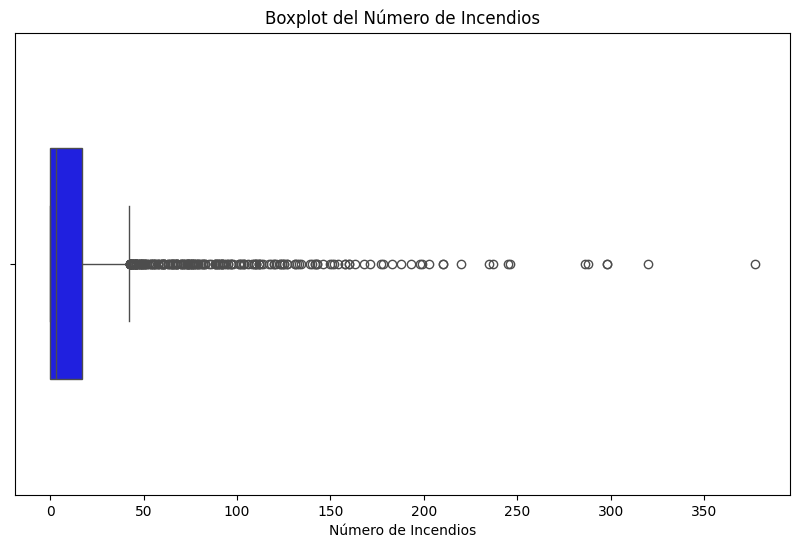

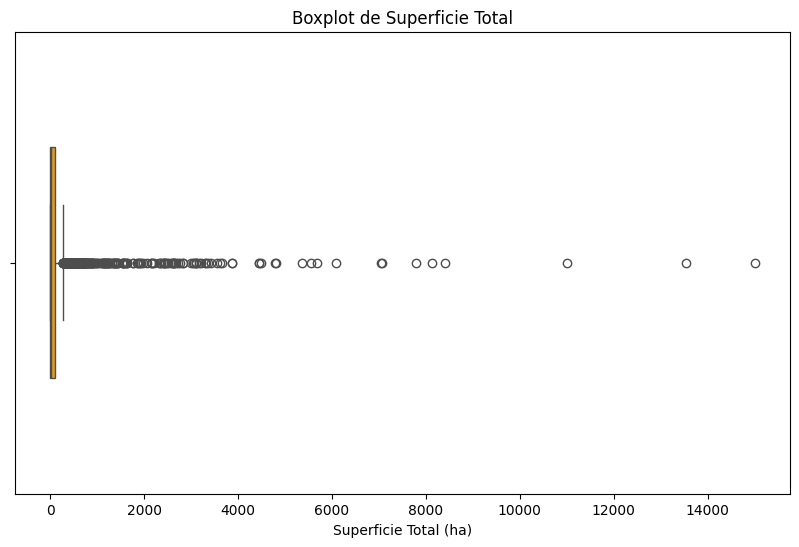

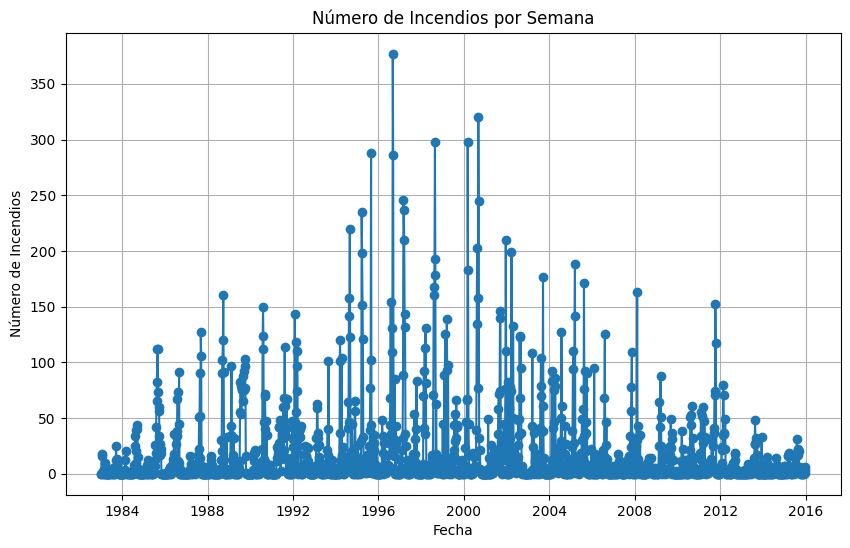

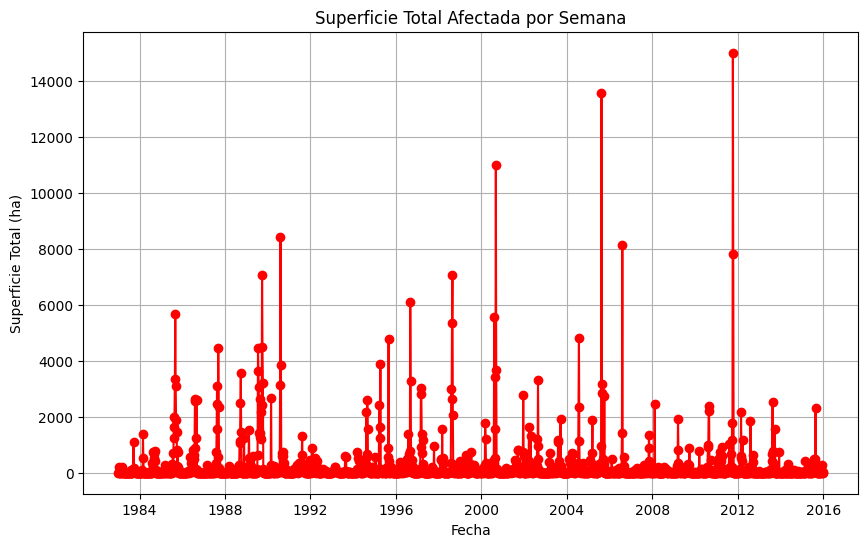

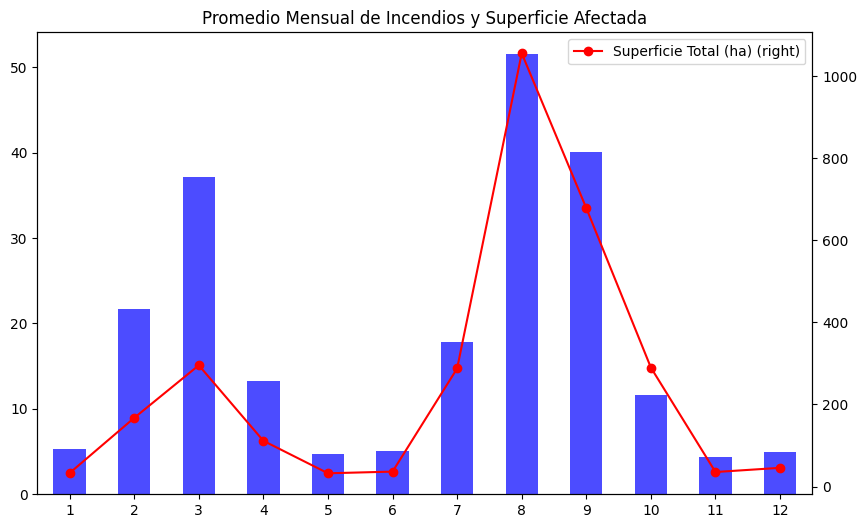

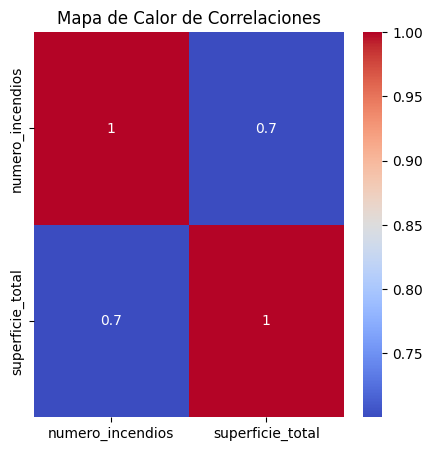

In [7]:
#TODO (Quitar seguramente o hacer manualmente con Data Wrangler)
# Posibles cosas

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x="numero_incendios", color="blue", width=0.5)
plt.title("Boxplot del Número de Incendios")
plt.xlabel("Número de Incendios")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x="superficie_total", color="orange", width=0.5)
plt.title("Boxplot de Superficie Total")
plt.xlabel("Superficie Total (ha)")
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df_train["semana"], df_train["numero_incendios"], marker="o")
plt.title("Número de Incendios por Semana")
plt.xlabel("Fecha")
plt.ylabel("Número de Incendios")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_train["semana"], df_train["superficie_total"], marker="o", color="red")
plt.title("Superficie Total Afectada por Semana")
plt.xlabel("Fecha")
plt.ylabel("Superficie Total (ha)")
plt.grid()
plt.show()

df_monthly = df_train.groupby("mes")[["numero_incendios", "superficie_total"]].mean().reset_index()
plt.figure(figsize=(10, 6))
df_monthly["numero_incendios"].plot(kind="bar", color="blue", alpha=0.7, label="Número de Incendios")
df_monthly["superficie_total"].plot(kind="line", color="red", marker="o", label="Superficie Total (ha)", secondary_y=True)
plt.xticks(ticks=range(12), labels=[f'{i+1}' for i in range(12)], rotation=0)
plt.title("Promedio Mensual de Incendios y Superficie Afectada")
plt.xlabel("Mes")
plt.legend()
plt.show()


corr = df_train[['numero_incendios', 'superficie_total']].corr(numeric_only=True)
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Mapa de Calor de Correlaciones")
plt.show()




### Time series

Tendremos que hacer 3 modelos con series temporales:
- Predecir numero de incendios
- Predecir hectareas quemadas
- Predecir ambas cosas a la vez

Después introducir también variables exógenas (meteorológicas).

Definimos una función que nos permita transformar el dataframe haciendo 'windowing', indicando el número de semanas de la ventana, las variables predictoras y las variables exógenas.

In [8]:
def create_windowed_dataframe(df, n_weeks, target_vars, exogenous_vars):
    """
    Crea un DataFrame con windowing para múltiples variables objetivo y exógenas,
    conservando la columna de semanas.
    
    Args:
        df (DataFrame): DataFrame con las columnas relevantes.
        n_weeks (int): Número de semanas previas a incluir.
        target_vars (list): Variables objetivo (a predecir).
        exogenous_vars (list): Variables exógenas.
        week_col (str): Nombre de la columna que contiene las semanas.
    
    Returns:
        df_windowed (DataFrame): DataFrame con las variables de entrada, salida y columna de semanas.
    """
    data = df.copy()
    features = target_vars + exogenous_vars
    columns = []  # Mantener la columna semana

    # Crear nombres de columnas para las semanas previas
    for week in range(-n_weeks, 0):
        columns.extend([f"{col}_week_{week}" for col in features])
    
    # Agregar columnas para las variables objetivo actuales
    columns.extend(target_vars)

    rows = []

    for i in range(n_weeks, len(data)):
        # Semana actual
        # current_week = data["semana"].iloc[i]

        # Inputs: Variables de las últimas n semanas
        input_window = data[features].iloc[i-n_weeks:i].values.flatten().tolist()

        # Outputs: Variables objetivo para la semana actual
        output_window = data[target_vars].iloc[i].values.tolist()

        # Combinar inputs, outputs y la semana actual
        rows.append(input_window + output_window)
    
    # Crear DataFrame final
    df_windowed = pd.DataFrame(rows, columns=columns)
    return df_windowed


#### Modelo 1: Número de incendios
Para el primer caso, utilizamos solo el número de incendios sin variables exógenas.

In [ ]:
target_vars = ["numero_incendios"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 10  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

Vamos a probar a utilizar Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-1]
y_train = df_windowed_train.iloc[:, -1]
X_test = df_windowed_test.iloc[:, 1:-1]
y_test = df_windowed_test.iloc[:, -1]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

Validación con TimeSeriesSplit

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el parámetro de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 50, 100],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo de muestras en una hoja
}

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score : {-grid_search.best_score_}")

# Mejor modelo después de la búsqueda
best_rf_1 = grid_search.best_estimator_

# Predecir en el conjunto de test
y_pred_test = best_rf_1.predict(X_test)

# Evaluar en el conjunto de test final
final_mae = mean_absolute_error(y_test, y_pred_test)

# Resultados
print(f"MAE en conjunto de test final: {final_mae:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

plt.plot(y_test, label="Real")
plt.plot(y_pred_test, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    errors.append(mean_absolute_error(y_val_fold, y_val_pred))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(errors))

# Evaluar
loss = model.evaluate(X_test_lstm, y_test.values)
print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)


plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()

#### Modelo 2: Hectáreas Quemadas
Para el segundo caso, utilizamos solo el número de hectáreas sin variables exógenas.

In [ ]:
target_vars = ["superficie_total"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 10  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

Vamos a probar a utilizar Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-1]
y_train = df_windowed_train.iloc[:, -1]
X_test = df_windowed_test.iloc[:, 1:-1]
y_test = df_windowed_test.iloc[:, -1]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

Validación con TimeSeriesSplit

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el parámetro de búsqueda
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 50, 100],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],    # Mínimo de muestras en una hoja
}

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mejor conjunto de hiperparámetros
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score : {-grid_search.best_score_}")

# Mejor modelo después de la búsqueda
best_rf_1 = grid_search.best_estimator_

# Predecir en el conjunto de test
y_pred_test = best_rf_1.predict(X_test)

# Evaluar en el conjunto de test final
final_mae = mean_absolute_error(y_test, y_pred_test)

# Resultados
print(f"MAE en conjunto de test final: {final_mae:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

plt.plot(y_test, label="Real")
plt.plot(y_pred_test, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    errors.append(mean_absolute_error(y_val_fold, y_val_pred))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(errors))

# Evaluar
loss = model.evaluate(X_test_lstm, y_test.values)
print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)


plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()


#### Modelo 3: Número de incendios y hectáreas quemadas

In [9]:
target_vars = ["numero_incendios", "superficie_total"]
exogenous_vars = []

# Supongamos que df_train ya contiene estas variables
n_weeks = 5  # Número de semanas previas
df_windowed_train = create_windowed_dataframe(df_train, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended = pd.concat([df_train.iloc[-n_weeks:], df_test]).reset_index(drop=True)
df_windowed_test = create_windowed_dataframe(df_test_extended, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test.head()

,numero_incendios_week_-5,superficie_total_week_-5,numero_incendios_week_-4,superficie_total_week_-4,numero_incendios_week_-3,superficie_total_week_-3,numero_incendios_week_-2,superficie_total_week_-2,numero_incendios_week_-1,superficie_total_week_-1,numero_incendios,superficie_total
0,4.0,124.78,0.0,0.00,6.0,279.82,3.0,41.29,1.0,3.26,0.0,0.0
1,0.0,0.00,6.0,279.82,3.0,41.29,1.0,3.26,0.0,0.00,0.0,0.0
2,6.0,279.82,3.0,41.29,1.0,3.26,0.0,0.00,0.0,0.00,0.0,0.0
3,3.0,41.29,1.0,3.26,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
4,1.0,3.26,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0


Vamos a probar a utilizar Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train.iloc[:, 1:-2]
y_train = df_windowed_train.iloc[:, -2:]
print(y_train)
X_test = df_windowed_test.iloc[:, 1:-2]
y_test = df_windowed_test.iloc[:, -2:]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

      numero_incendios  superficie_total
0                  2.0              3.00
1                  1.0              9.00
2                  0.0              0.00
3                  1.0              8.00
4                 10.0            196.60
...                ...               ...
1712               4.0            124.78
1713               0.0              0.00
1714               6.0            279.82
1715               3.0             41.29
1716               1.0              3.26

[1717 rows x 2 columns]


Validación con TimeSeriesSplit

MAE promedio por variable objetivo: [ 16.29116203 292.49389534]
MAE en conjunto de test final (numero_incendios): 5.6321
MAE en conjunto de test final (superficie_total): 327.4714


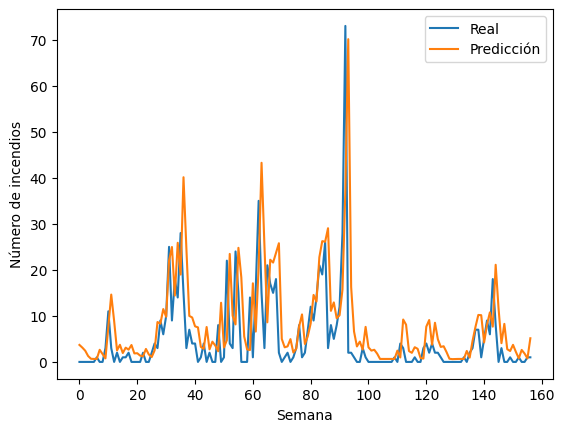

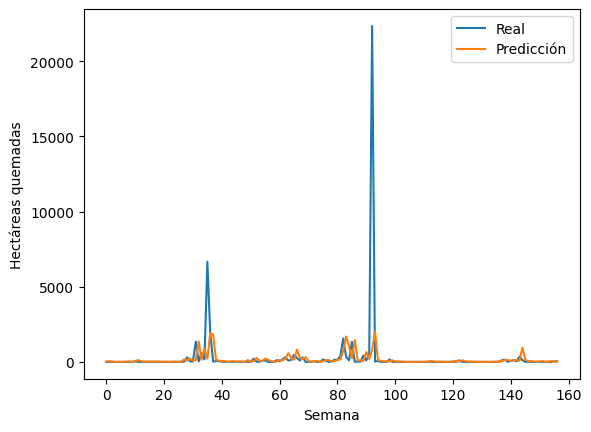

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define el modelo con hiperparámetros elegidos
rf = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=10,
    random_state=42
))

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Para almacenar los errores en cada split
mae_scores = []

# Realizar la validación cruzada manual
for train_index, val_index in tscv.split(X_train):
    # Dividir los datos en entrenamiento y validación utilizando índices posicionales
    X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entrenar el modelo
    rf.fit(X_train_split, y_train_split)
    
    # Hacer predicciones
    y_pred = rf.predict(X_val_split)
    # Calcular MAE para ambas variables objetivo
    mae_split = mean_absolute_error(y_val_split, y_pred, multioutput='raw_values')  # Devuelve un array con el MAE de cada salida
    mae_scores.append(mae_split)

# Calcular el promedio del MAE para cada variable objetivo
mean_mae = np.mean(mae_scores, axis=0)

print(f"MAE promedio por variable objetivo: {mean_mae}")

# Predecir en el conjunto de test
y_pred_test = rf.predict(X_test)

# Evaluar en el conjunto de test final
final_mae1 = mean_absolute_error(y_test["numero_incendios"], y_pred_test[:, 0])
final_mae2 = mean_absolute_error(y_test["superficie_total"], y_pred_test[:, 1])

# Resultados
print(f"MAE en conjunto de test final (numero_incendios): {final_mae1:.4f}")
print(f"MAE en conjunto de test final (superficie_total): {final_mae2:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

# plt.plot(y_test, label="Real")
# plt.plot(y_pred_test, label="Predicción")
# plt.legend()
# plt.show()

plt.figure()
plt.plot(y_test["numero_incendios"].values, label="Real")
plt.plot(y_pred_test[:, 0], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()

plt.figure()
plt.plot(y_test["superficie_total"].values, label="Real")
plt.plot(y_pred_test[:, 1], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()


También probamos el entrenamiento con el modelo LSTM, el cual está pensando específicamente para series temporales, también permite múltiples variables de entrada y de salida, y exógenas.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Semilla aleatoria para reproducir los resultados
tf.keras.utils.set_random_seed(42)

# Preparamos
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# print("X_train:", X_train_lstm)

X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
# print("X_test:", X_test_lstm)

y_train_lstm = y_train.values.reshape((y_train.shape[0], y_train.shape[1], 1))
# print("X_train:", X_train_lstm)

y_test_lstm = y_test.values.reshape((y_test.shape[0], y_test.shape[1], 1))
# print("X_test:", X_test_lstm)

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits=5)
errors = []

for train_idx, val_idx in tscv.split(X_train_lstm):
    X_train_fold, X_val_fold = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_train_fold, y_val_fold = y_train_lstm[train_idx], y_train_lstm[val_idx]

    # Entrena el modelo en cada partición
    model = Sequential([
        Input(shape=(X_train.shape[1], 1)),
        LSTM(64, activation='relu'),
        Dense(2) # Vamos a obtener 2 salidas
    ])
    model.compile(optimizer='adam', loss='mae')
    model.fit(X_train_fold, y_train_fold, epochs=10, verbose=0, batch_size=32)

    # Evalúa
    y_val_pred = model.predict(X_val_fold)
    y_val_fold = np.array(y_val_fold).reshape(-1, 2)
    y_val_fold = pd.DataFrame(y_val_fold, columns=['numero_incendios', 'superficie_total'])
    errors.append(mean_absolute_error(y_val_fold, y_val_pred, multioutput='raw_values'))

# Promedia el error de validación
print("Error promedio de validación cruzada:", np.mean(np.array(errors), axis=0))

# Evaluar
# print("y_test", y_test.values)
# loss = model.evaluate(X_test_lstm, y_test.values)
# print(f"MAE en el conjunto de test final: {loss}")

# Predicciones
y_pred = model.predict(X_test_lstm)

error_num_incendios = mean_absolute_error(y_test.iloc[:, 0], y_pred[:, 0])  # error para la primera variable
error_superficie = mean_absolute_error(y_test.iloc[:, 1], y_pred[:, 1])     # error para la segunda variable
# Imprimir los resultados
print(f"Error num incendios: {error_num_incendios}")
print(f"Error superficie: {error_superficie}")

# plt.plot(y_test.values, label="Real")
# plt.plot(y_pred, label="Predicción")
# plt.legend()
# plt.show()

plt.figure()
plt.plot(y_test["numero_incendios"].values, label="Real")
plt.plot(y_pred[:, 0], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()

plt.figure()
plt.plot(y_test["superficie_total"].values, label="Real")
plt.plot(y_pred[:, 1], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()

In [ ]:
# plt.figure()
# plt.plot(y_test["numero_incendios"].values, label="Real")
# plt.plot(y_pred_test[:, 0], label="Predicción")
# plt.legend()
# plt.xlabel("Semana")
# plt.ylabel("Número de incendios")
# plt.show()

# plt.figure()
# plt.plot(y_test["superficie_total"].values, label="Real")
# plt.plot(y_pred_test[:, 1], label="Predicción")
# plt.legend()
# plt.xlabel("Semana")
# plt.ylabel("Hectáreas quemadas")
# plt.show()

#### Modelo 4: Introducir variables exógenas

In [ ]:
data_path="data/fires-weather.csv"
try:
    df_full=pd.read_csv(data_path)
except Exception as error:
    print(f"Error while importing the excel file: {error}")

df_full.head()

In [ ]:
# Dividir los datos en train y test
df_train_full = df_full[df_full['Anno'] <= 2015].reset_index(drop=True) #Modificados
df_test_full = df_full[df_full['Anno'] >= 2016].reset_index(drop=True)

# Calcular tamaños de train y test
train_size = len(df_train_full)
test_size = len(df_test_full)
total_size = len(df_full)

# Calcular porcentajes
train_percentage = (train_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Mostrar resultados
print(f"\nTamaño total: {total_size}")
print(f"Train: {train_size} filas ({train_percentage:.2f}%)")
print(f"Test: {test_size} filas ({test_percentage:.2f}%)")

# Verificar los resultados
print("Train:")
print(df_train_full.head(), "\n--------------\n", df_train_full.tail())
print("\nTest:")
print(df_test_full.head(), "\n--------------\n", df_test_full.tail()) # No se usará hasta el final

In [7]:
target_vars = ["numero_incendios", "superficie"]
exogenous_vars = ["Temp Media (oC)_mean", "Temp Media (oC)_var", "Temp Max (oC)_mean", "Temp Max (oC)_var", \
                  "Temp Minima (oC)_mean","Temp Minima (oC)_var", "Humedad Media (%)_mean", "Humedad Media (%)_var", \
                  "Humedad Max (%)_mean", "Humedad Max (%)_var", "Humedad Min (%)_mean", "Humedad Min (%)_var", \
                  "Velviento (m/s)_mean", "Velviento (m/s)_var", "DirViento (o)_mean", "DirViento (o)_var", \
                  "VelVientoMax (m/s)_mean", "VelVientoMax (m/s)_var", "Precipitacion (mm)_mean", "Precipitacion (mm)_var"]

# Supongamos que df_train ya contiene estas variables
n_weeks = 5  # Número de semanas previas
df_windowed_train_full = create_windowed_dataframe(df_train_full, n_weeks, target_vars, exogenous_vars)

# Concatenar las últimas n semanas del train al inicio del test para poder predecir las primeras semanas de test
df_test_extended_full = pd.concat([df_train_full.iloc[-n_weeks:], df_test_full]).reset_index(drop=True)
df_windowed_test_full = create_windowed_dataframe(df_test_extended_full, n_weeks, target_vars, exogenous_vars)

# Revisar los primeros registros
df_windowed_test_full.head()

,numero_incendios_week_-5,superficie_week_-5,Temp Media (oC)_mean_week_-5,Temp Media (oC)_var_week_-5,Temp Max (oC)_mean_week_-5,Temp Max (oC)_var_week_-5,Temp Minima (oC)_mean_week_-5,Temp Minima (oC)_var_week_-5,Humedad Media (%)_mean_week_-5,Humedad Media (%)_var_week_-5,...,Velviento (m/s)_mean_week_-1,Velviento (m/s)_var_week_-1,DirViento (o)_mean_week_-1,DirViento (o)_var_week_-1,VelVientoMax (m/s)_mean_week_-1,VelVientoMax (m/s)_var_week_-1,Precipitacion (mm)_mean_week_-1,Precipitacion (mm)_var_week_-1,numero_incendios,superficie
0,4.0,124.78,5.6657,13.8849,12.4671,43.6552,1.5043,5.2197,94.2286,68.9890,...,1.8625,1.3588,189.9500,154.2700,7.4350,14.9442,4.7000,28.3867,0.0,0.0
1,0.0,0.00,6.5543,4.9949,11.9557,13.2954,2.1057,2.7679,94.5286,33.6857,...,1.1814,0.2651,218.7429,85.3295,5.7486,2.3563,18.1143,184.7314,0.0,0.0
2,6.0,279.82,14.8400,5.2469,18.2957,5.0829,9.9757,17.1079,64.0514,208.5447,...,0.8343,0.1402,145.2371,6466.0176,4.4986,3.2673,5.3714,45.5924,0.0,0.0
3,3.0,41.29,9.8814,10.2298,15.3414,7.7061,4.6786,27.2173,76.3771,162.0380,...,0.6443,0.1645,177.4714,821.6090,3.4714,2.2258,1.4000,3.2933,0.0,0.0
4,1.0,3.26,10.2250,7.7244,15.3450,5.6654,5.5975,4.6825,77.9000,113.6867,...,0.7514,0.1805,200.0357,4838.8123,4.5800,3.4753,2.4857,17.9314,0.0,0.0


Vamos a probar a utilizar Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Separamos en X e y los datos ya en ventana
X_train = df_windowed_train_full.iloc[:, 1:-2]
y_train = df_windowed_train_full.iloc[:, -2:]
# print(y_train)
X_test = df_windowed_test_full.iloc[:, 1:-2]
y_test = df_windowed_test_full.iloc[:, -2:]

# Crear el modelo
rf = RandomForestRegressor(random_state=42)

Validación con TimeSeriesSplit

MAE promedio por variable objetivo: [  9.4094533  262.62650779]
MAE en conjunto de test final (numero_incendios): 5.1165
MAE en conjunto de test final (superficie_total): 316.1224


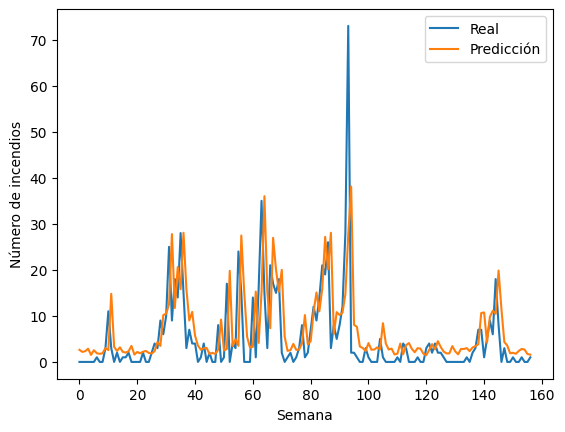

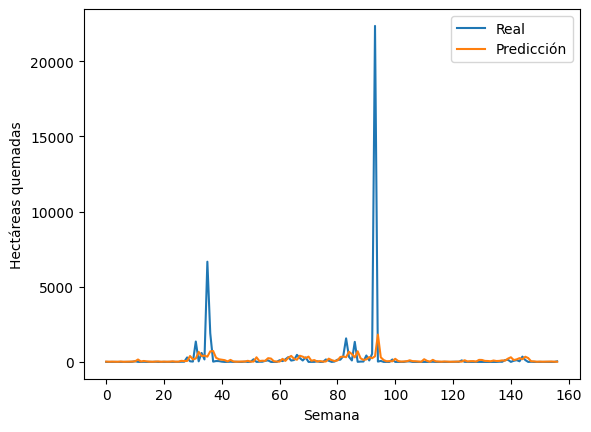

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define el modelo con hiperparámetros elegidos
rf = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=10,
    random_state=42
))

# Configurar TimeSeriesSplit
n_splits = 5  # Número de divisiones para validación
tscv = TimeSeriesSplit(n_splits=n_splits)

# Para almacenar los errores en cada split
mae_scores = []

# Realizar la validación cruzada manual
for train_index, val_index in tscv.split(X_train):
    # Dividir los datos en entrenamiento y validación utilizando índices posicionales
    X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Entrenar el modelo
    rf.fit(X_train_split, y_train_split)
    
    # Hacer predicciones
    y_pred = rf.predict(X_val_split)
    # Calcular MAE para ambas variables objetivo
    mae_split = mean_absolute_error(y_val_split, y_pred, multioutput='raw_values')  # Devuelve un array con el MAE de cada salida
    mae_scores.append(mae_split)

# Calcular el promedio del MAE para cada variable objetivo
mean_mae = np.mean(mae_scores, axis=0)

print(f"MAE promedio por variable objetivo: {mean_mae}")

# Predecir en el conjunto de test
y_pred_test = rf.predict(X_test)

# Evaluar en el conjunto de test final
final_mae1 = mean_absolute_error(y_test["numero_incendios"], y_pred_test[:, 0])
final_mae2 = mean_absolute_error(y_test["superficie"], y_pred_test[:, 1])

# Resultados
print(f"MAE en conjunto de test final (numero_incendios): {final_mae1:.4f}")
print(f"MAE en conjunto de test final (superficie_total): {final_mae2:.4f}")
# print(f"Predicciones en conjunto de test: {y_pred_test}")

# plt.plot(y_test, label="Real")
# plt.plot(y_pred_test, label="Predicción")
# plt.legend()
# plt.show()

plt.figure()
plt.plot(y_test["numero_incendios"].values, label="Real")
plt.plot(y_pred_test[:, 0], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Número de incendios")
plt.show()

plt.figure()
plt.plot(y_test["superficie"].values, label="Real")
plt.plot(y_pred_test[:, 1], label="Predicción")
plt.legend()
plt.xlabel("Semana")
plt.ylabel("Hectáreas quemadas")
plt.show()
